In this notebook I am writing a practice scenario for controlling assets based on perceptions of residents
Here Gamma is the Ann Arbor stormwater network
The initial control algorithm can be a rules based algorithm that adjusts the water purely based on if the water level is above or below a certain threshold
For the purposes of the first analysis we will not allow the depth to drop below 30% max depth or above 90% max depth

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GPyOpt.methods import BayesianOptimization
import pystorms

# set matplotlib RC params
plt.rcParams.update({'font.size':18})
plt.style.use('seaborn-whitegrid')

In [8]:
# Initialize the uncontrolled scenario
uncontrolled_env = pystorms.scenarios.gamma()
done = False

while not done:
    # Query the current state of the simulation
    state = uncontrolled_env.state()

    # Initilizae actions to have each asset open
    actions = np.ones(11)

    # Set the action and progress the simulation with the actions
    done = uncontrolled_env.step(actions)

# Calculate the performance measure for the uncontrolled simulation

uncontrolled_performance = sum(uncontrolled_env.data_log['performance_measure'])

In [11]:
# Initialize the controller 
def controller_equal(state, max_depths):
    new_actions = np.ones(len(state))
    # Initialize the equal filling parameters c which regulates reactivity to control
    # theta is the flashiness control
    c=1.5
    theta = 0.24

    depths = state
    f = depths/max_depths
    f_mean = np.mean(f)

    for i in range(0,len(f)):
        if f[i] > f_mean:
            new_actions[i] = c*(f[i] - f_mean)
        elif f_mean-f[i] <= theta:
            new_actions[i] = f_mean
        else:
            new_actions[i] = 0

        new_actions[i] = min(new_actions[i], 1)
        new_actions[i] = max(new_actions[i], 0)
    
    return new_actions

basin_max_depths = [10.,10.,10.,10.,10.,20.,10.,10.,10.1,13.72,14.96]

controlled_env = pystorms.scenarios.gamma()
done = False
while not done:
    state = controlled_env.state()
    actions = controller_equal(state, basin_max_depths)
    done = controlled_env.step(actions)

equ_filling_performance = sum(controlled_env.data_log['performance_measure']) 

In [14]:
def controller_resident(state, max_depths):
    new_actions = np.ones(len(state))

    depths = state
    
    
    for i in range(0, len(depths)):
        if (depths[i]/max_depths[i]) > 0.8:
            new_actions[i] = 1
        elif (depths[i]/max_depths[i]) < 0.3:
            new_actions[i] = 0
        else:
            new_actions[i] = 0.3
    
    return new_actions

res_cont_env = pystorms.scenarios.gamma()
done = False
while not done:
    state = res_cont_env.state()
    actions = controller_resident(state, basin_max_depths)
    done = res_cont_env.step(actions)

resident_performance = sum(res_cont_env.data_log['performance_measure'])

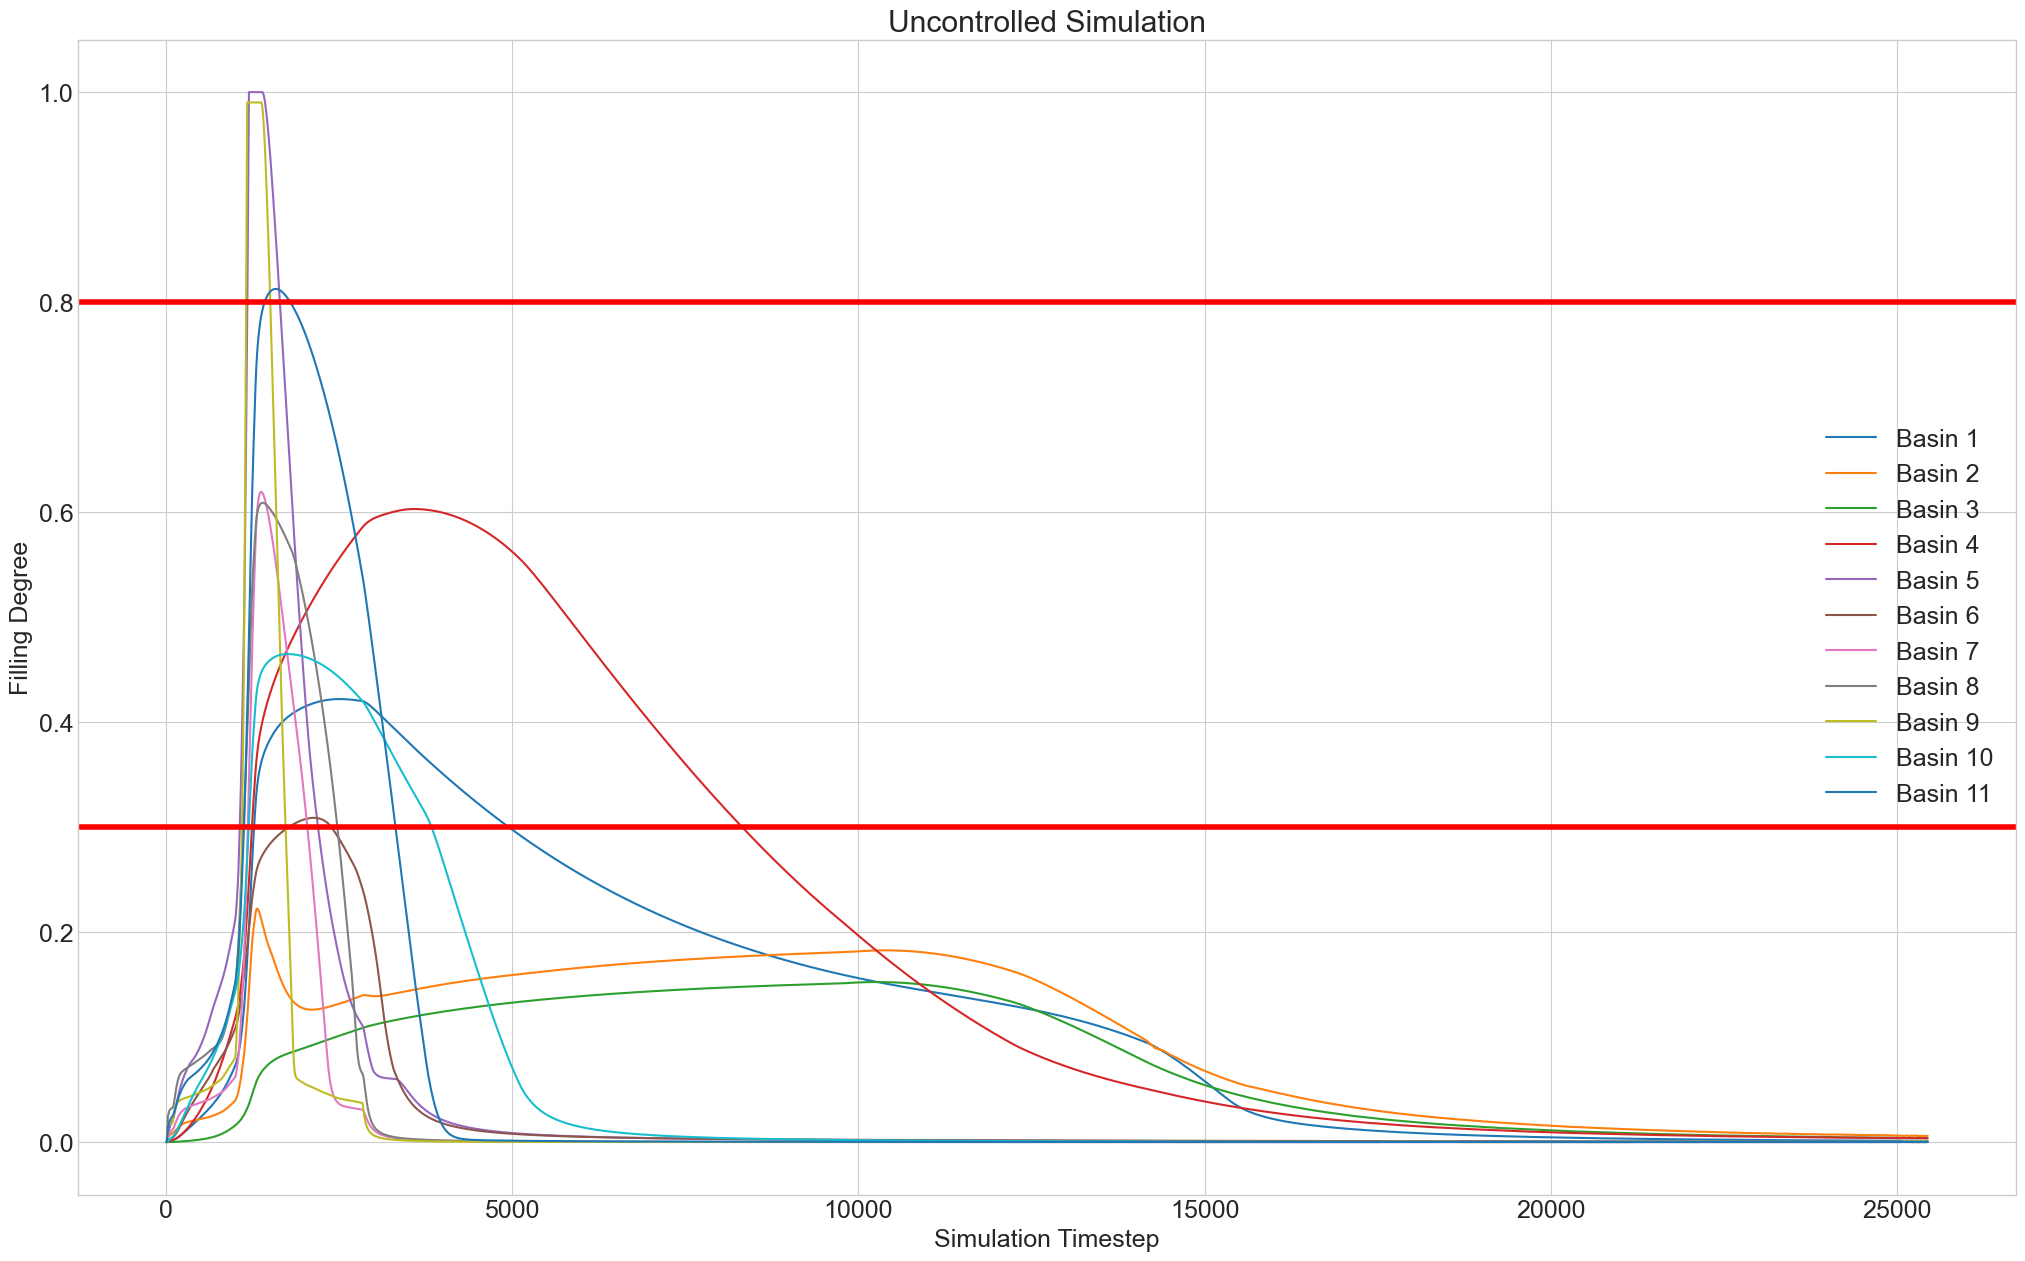

400221923.1345468


In [31]:
plt.figure(figsize = (25,15), dpi = 100)
for i in range(1, 12):
    plt.plot(np.array(uncontrolled_env.data_log['depthN'][str(i)])/(basin_max_depths[i-1]), label = 'Basin '+str(i))
plt.xlabel('Simulation Timestep')
plt.ylabel('Filling Degree')
plt.title('Uncontrolled Simulation')
plt.axhline(0.80, linewidth = 4.0, color = 'red')
plt.axhline(0.30, linewidth = 4.0, color = 'red')
plt.legend()
plt.show()
print(uncontrolled_performance)

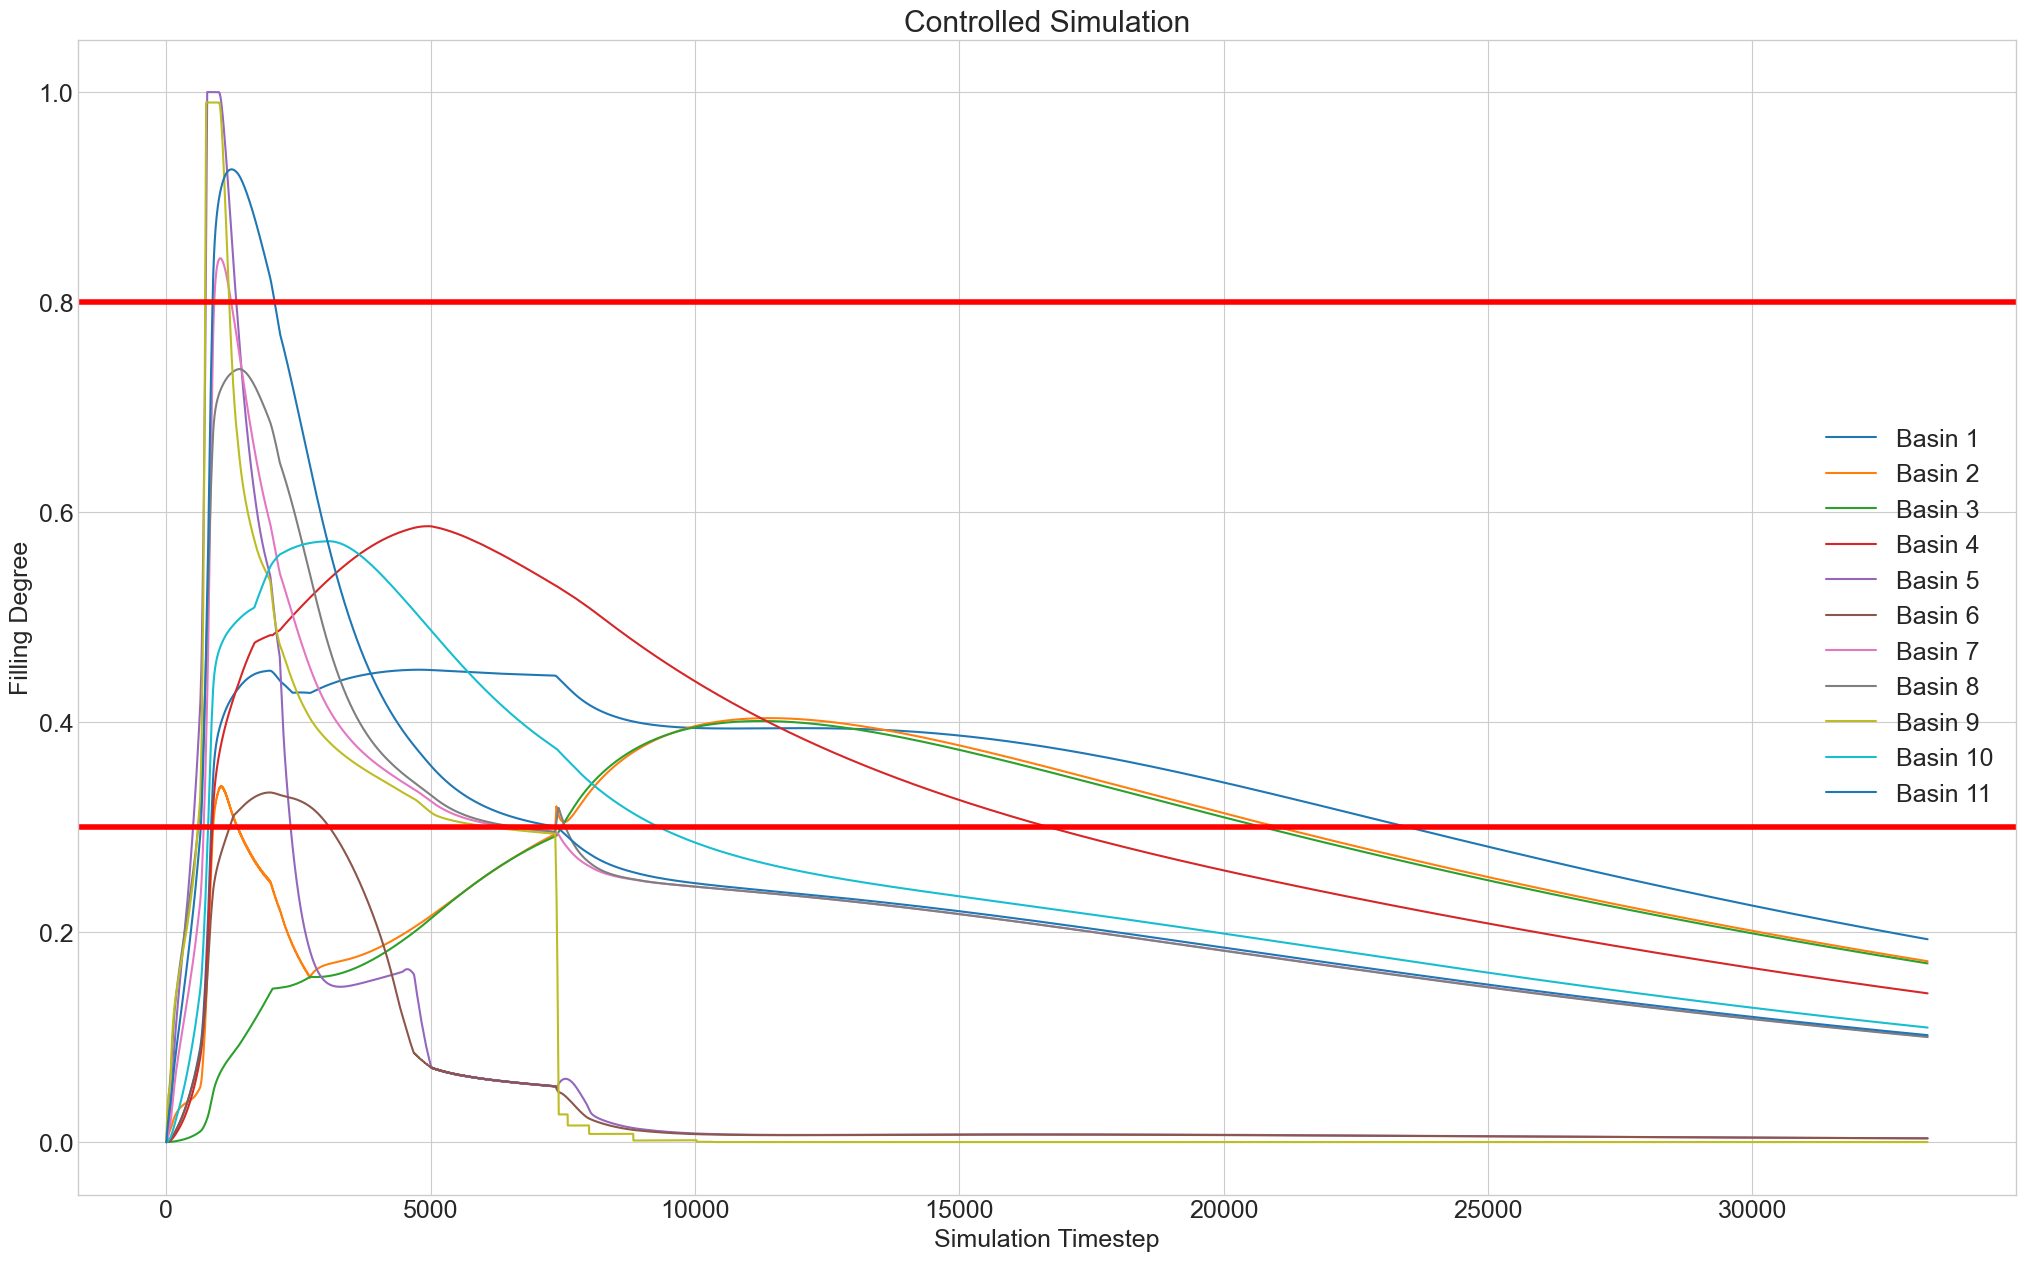

477627925.06072134


In [34]:
plt.figure(figsize = (25,15), dpi = 100)
for i in range(1, 12):
    plt.plot(np.array(controlled_env.data_log['depthN'][str(i)])/(basin_max_depths[i-1]), label = 'Basin '+str(i))
plt.xlabel('Simulation Timestep')
plt.ylabel('Filling Degree')
plt.title('Controlled Simulation')
plt.axhline(0.80, linewidth = 4.0, color = 'red')
plt.axhline(0.30, linewidth = 4.0, color = 'red')
plt.legend()
plt.show()
print(equ_filling_performance)

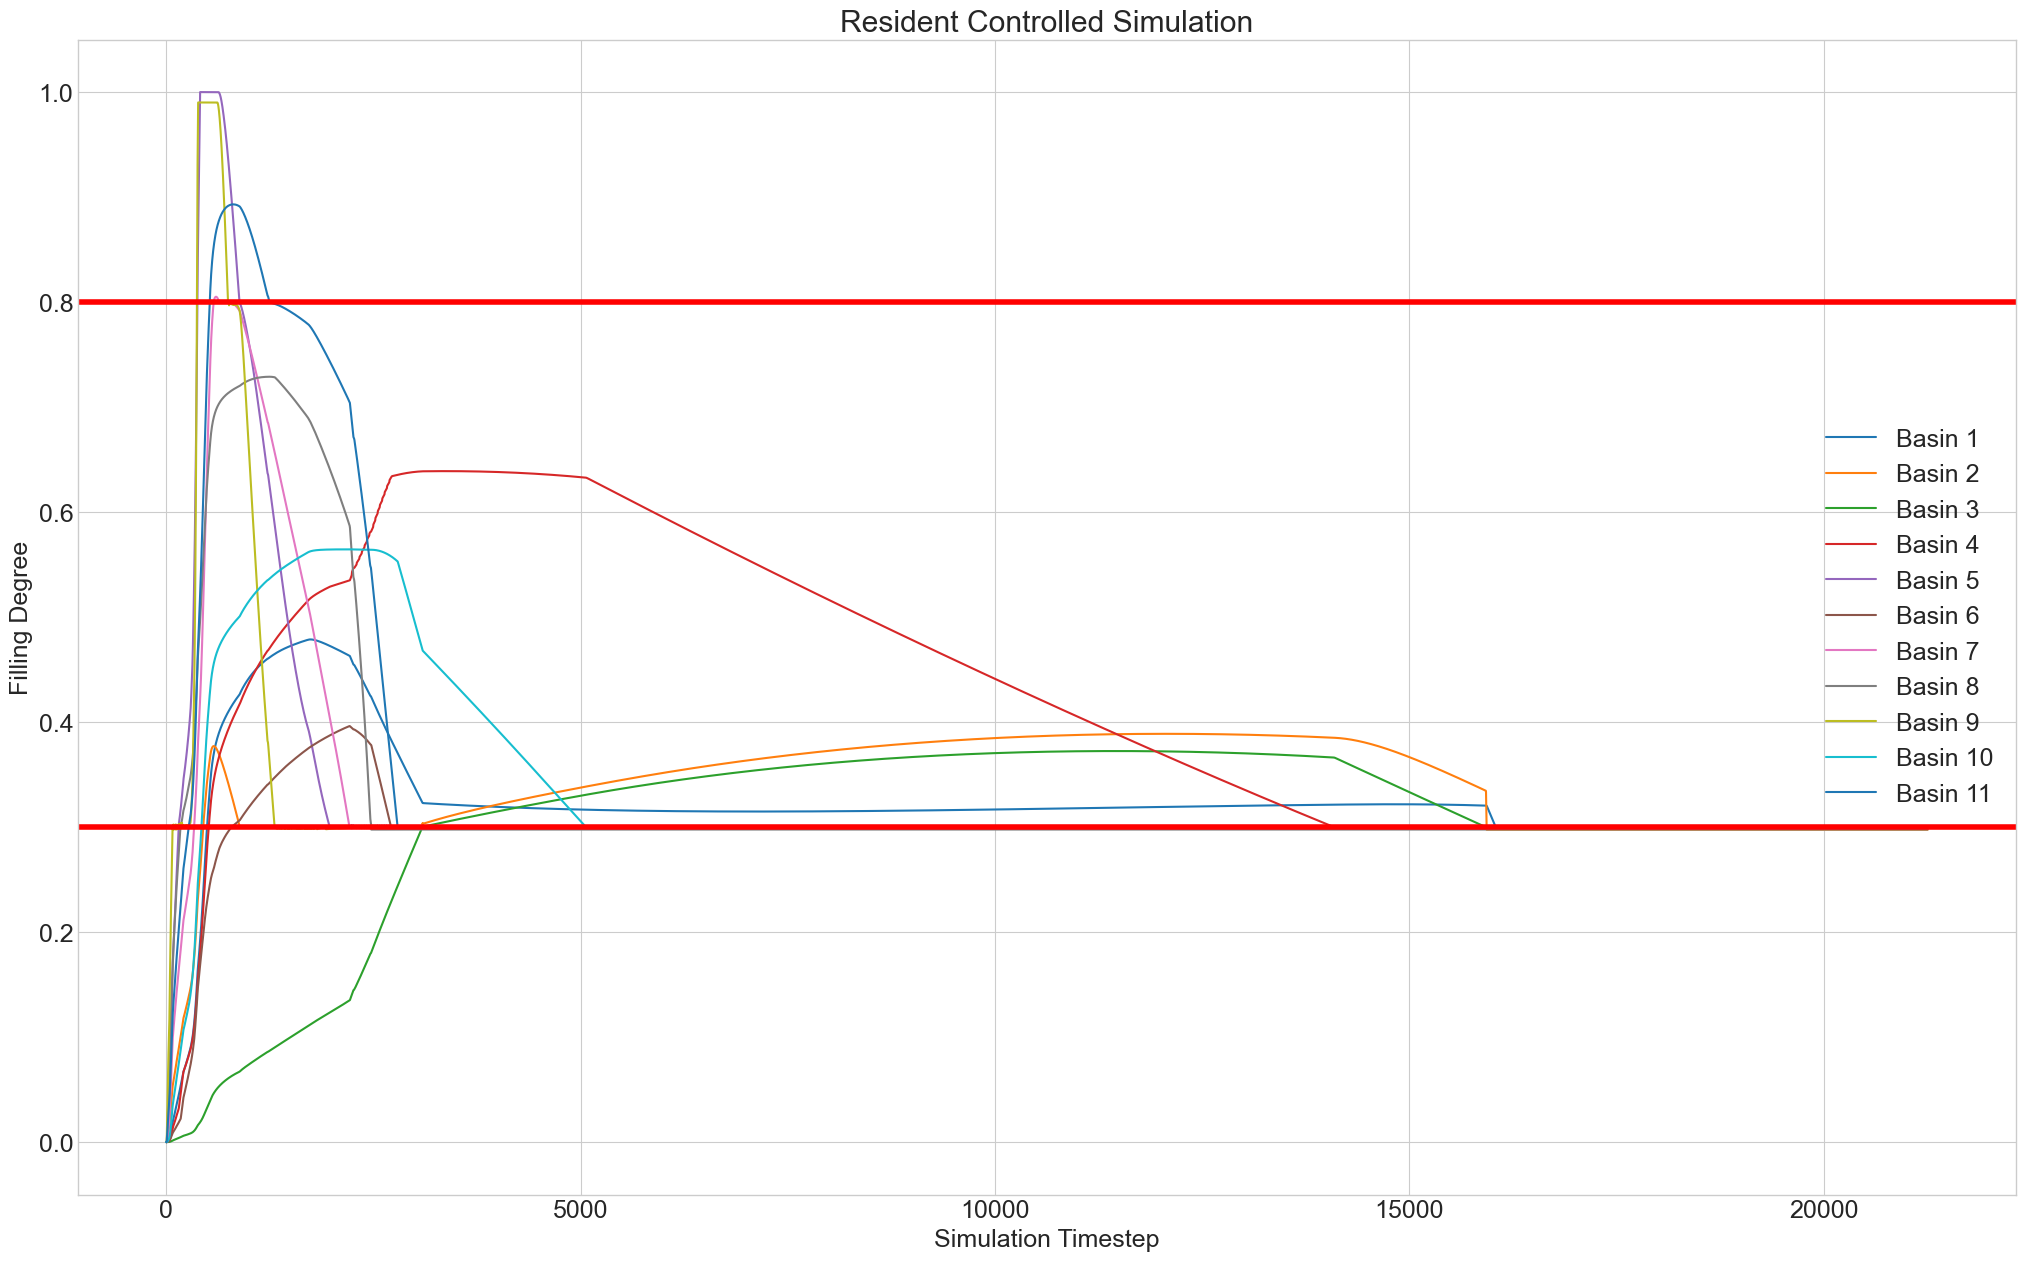

460723192.06474924


In [35]:
plt.figure(figsize = (25,15), dpi = 100)
for i in range(1, 12):
    plt.plot(np.array(res_cont_env.data_log['depthN'][str(i)])/(basin_max_depths[i-1]), label = 'Basin '+str(i))
plt.xlabel('Simulation Timestep')
plt.ylabel('Filling Degree')
plt.title('Resident Controlled Simulation')
plt.axhline(0.80, linewidth = 4.0, color = 'red')
plt.axhline(0.30, linewidth = 4.0, color = 'red')
plt.legend()
plt.show()
print(resident_performance)